In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 26.7MB/s 
     |████████████████████████████████| 3.3MB 45.1MB/s 
     |████████████████████████████████| 901kB 50.7MB/s 


In [ ]:
import torch
import numpy as np
import pandas as pd
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-4_H-256_A-4')
model = AutoModel.from_pretrained('google/bert_uncased_L-4_H-256_A-4')

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We have a dataset containing 10,000 restaurant reviews on Yelp. Each review contains a star rating field (1 to 5) and a text field where the user comments on their experience at the restaurant.

3-star and 4-star reviewers aren't likely to promote the restaurant to friends and colleagues. Read more about [Net Promoter Scores](https://en.wikipedia.org/wiki/Net_Promoter). Ratings of less than 5 stars oftenly include a negative component explaining why the rating was not 5 stars.

Classify star ratings of 1, 2, 3, and 4 as negative (0). 

Classify star ratings of  5 as positive (1).

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/mayank100sharma/Sentiment-Analysis-on-Yelp-Reviews/master/yelp.csv').head(4000)
df['sentiment'] = df['stars'].map({1:0, 2:0, 3:0, 4:0, 5:1})
df['sentiment'].value_counts()

0    2654
1    1346
Name: sentiment, dtype: int64

In [ ]:
max_len = 180
df['text'] = df['text'].str.split(n=max_len).str[:max_len].str.join(' ')
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
padded = np.array([i[:min(max_len, len(i))] + [0]*(max_len-min(max_len, len(i))) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

print(padded.shape)
print(attention_mask.shape)

(4000, 180)
(4000, 180)


In [ ]:
input = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    bert_output = model(input, attention_mask=attention_mask)

In [ ]:
# Retrieve all sentences
# Only retrieve the [CLS] token
# Retrieve all units of output layer
features = np.array(bert_output[0][:,0,:])
labels = np.array(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(features, labels)

classifier = Sequential()
classifier.add(Input(shape=(256,)))
classifier.add(Dense(1, activation='sigmoid'))
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 257       
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
history = classifier.fit(X_train, y_train, epochs=16, validation_split=0.05, verbose=0, batch_size=64)

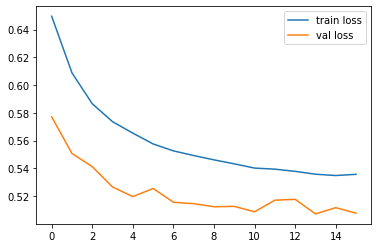

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend()
plt.show()

In [ ]:
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Accuracy: {round(100*accuracy, 1)}%')

32/32 [==============================] - 0s 1ms/step - loss: 0.5239 - accuracy: 0.7300
Accuracy: 73.0%


### Test on new data

In [ ]:
sample = 'Our waiter took a long time. The food was cold. Overpriced.'
sample_token = tokenizer.encode(sample, add_special_tokens=True)
sample_padded = np.array(sample_token + [0]*(max_len-len(sample_token)))
attention_mask = np.where(sample_padded != 0, 1, 0)

sample_padded = np.reshape(sample_padded, newshape=(1,-1))
attention_mask = np.reshape(attention_mask, newshape=(1,-1))

input = torch.tensor(sample_padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input, attention_mask=attention_mask)

features = last_hidden_states[0][:,0,:].numpy()
sample_prediction = classifier.predict(features)

print(sample_prediction.flatten())
if sample_prediction.flatten()[0] > 0.5:
    print('Positive Sentiment')
else:
    print('Negative Sentiment')

[0.13900475]
Negative Sentiment


Save the model

In [ ]:
classifier.save('drive/MyDrive/models')

INFO:tensorflow:Assets written to: drive/MyDrive/models/assets
